In [1]:
%cd ..
from econnet import data
from econnet import simulator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx

/Users/andrewma/Desktop/stat222/Economic_Networks


/Users/andrewma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Delta-function shock effects (relative)')

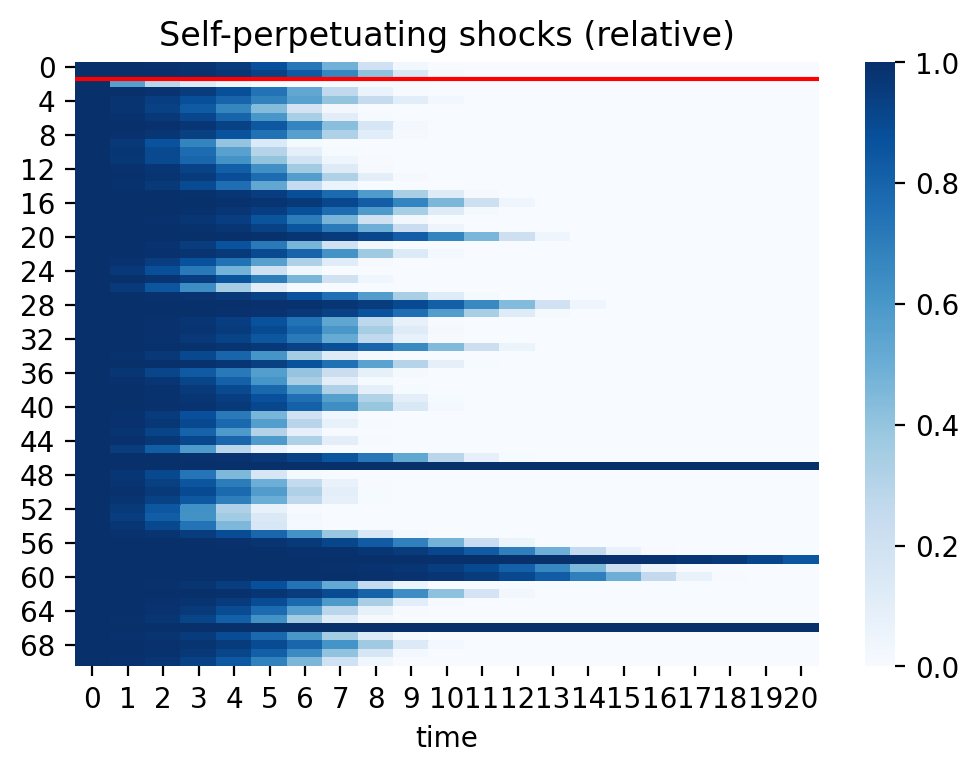

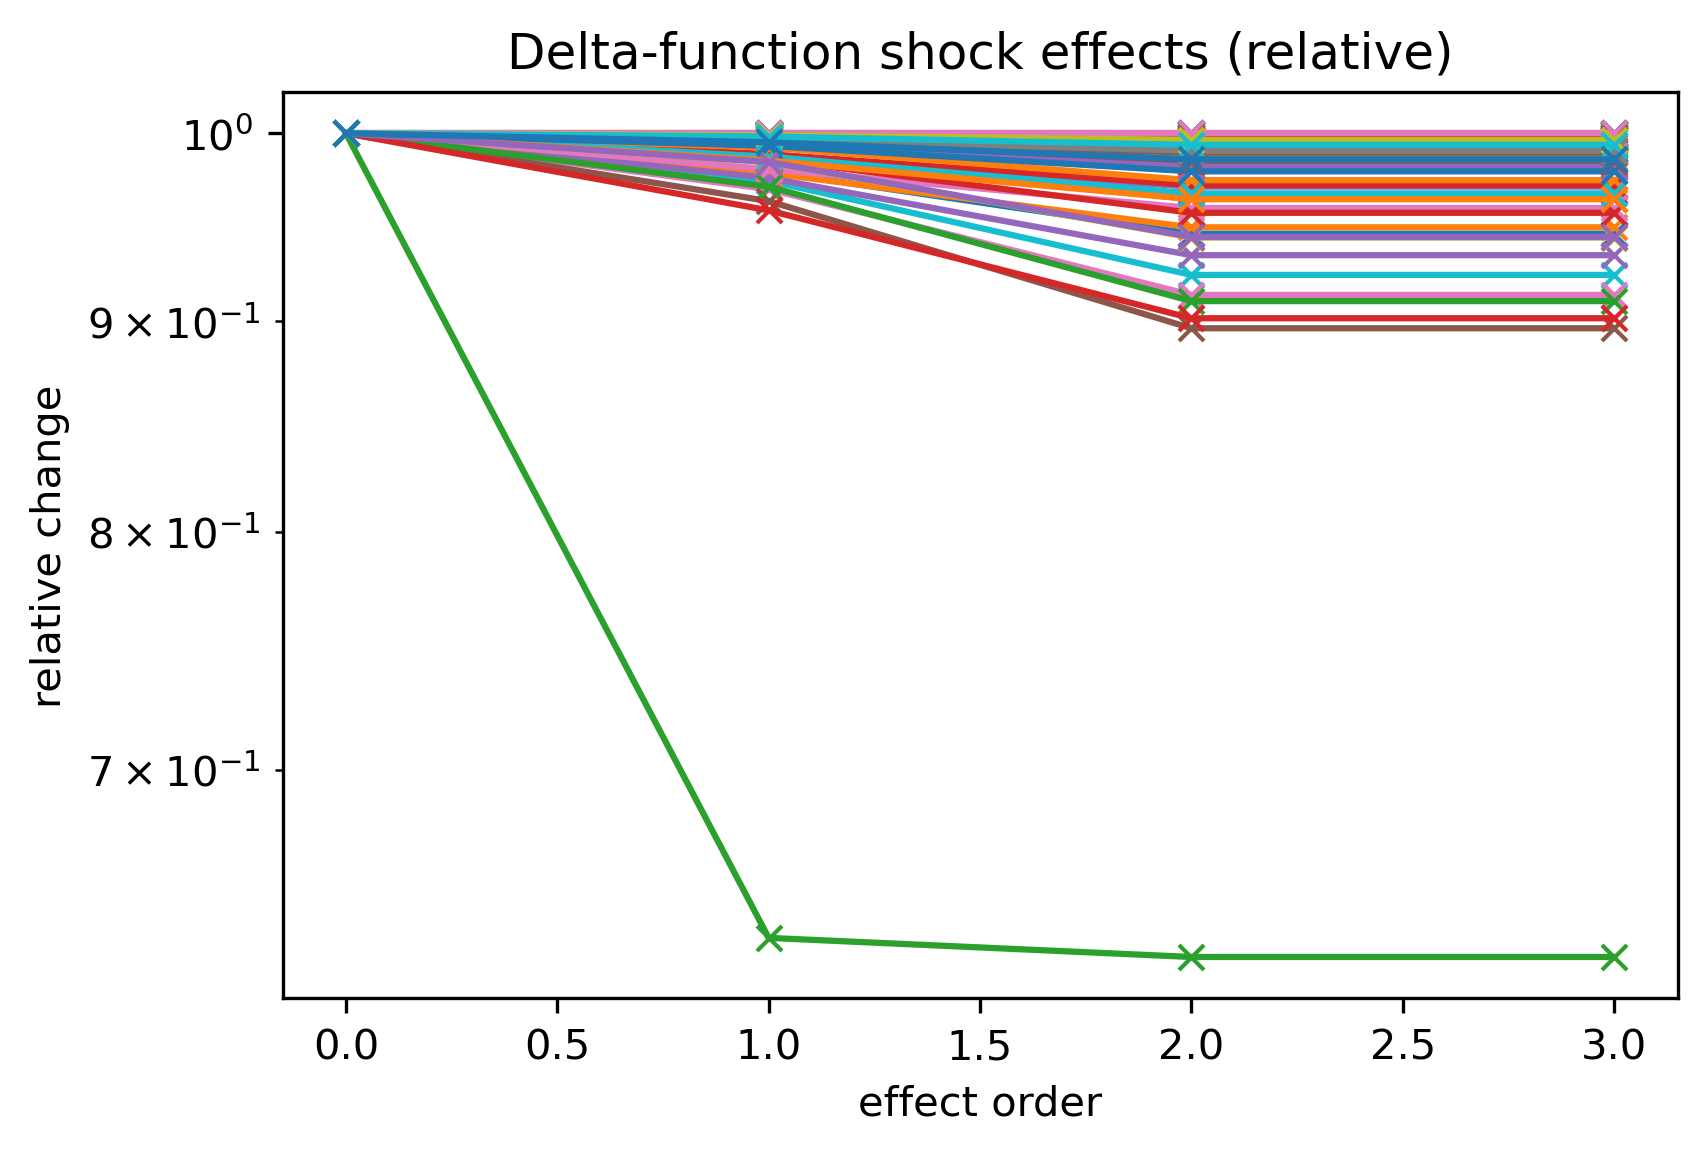

In [2]:
# naive implementation for testing purposes, keep propagating self-effects
def simulateAll(y, H, dz, niter=20):
    """Self-perpetuating perturbation"""
    ys = [y]

    for i in range(niter):
        dly = H @ dz
        y = np.exp(np.log(y) + dly)
        ys.append(y)

        # the previous effect becomes the shock
        dz = dly

    return ys


def simulateOneTime(y, H, dz, niter=20):
    """One-time shock
       The iterations correspond to the ORDER of perturbation effects"""

    ys = [y]
    seen = set()

    for i in range(niter):
        dly = H @ dz
        y = np.exp(np.log(y) + dly)
        ys.append(y)

        # TODO: use an eps cutoff instead of strict 0?
        # the shock propagates downstream
        seen.update([i for i in np.where(dz)[0]])

        if len(seen) == len(y):
            break
        if sum(dly) == 0:
            break

        # only set the ones that were perturbed for the first time
        # as the new perturbation
        dz = np.zeros(dz.shape)
        mask = sorted(set(range(len(y))) - seen)
        dz[mask] = dly[mask]
    return ys


# TODO: producer vs industry prices fields?
# initial state - using VALUE ADDED
u = data.Use(2020)
y = u.table.loc["Value Added (producer prices)", :][:data.Table.nInd]
ys = []

H = data.I2IReqs(2020).make_adjacency()

dz = np.zeros(y.shape[0])
# dz[np.random.randint(0, y.shape[0])] = - np.random.rand()
# let's shock housing - it doesn't make sense to shock more than exp(-0.5)
# = 40% decrease
# dz[48] = - np.random.uniform(0, 0.5)

# "Oil & Gas"
# dz[2] = - np.random.uniform(0, 0.5)
dz[2] = -.4

all_run = simulator.simulateAll(y=y, H=H, dz=dz)
ar = np.array(all_run)

#NOTE: Housing -index 48 - is upstream from real estate and unaffected!!!
plt.figure(dpi = 200) 
sns.heatmap((ar / ar[0, :]).T, cmap="Blues")
plt.xlabel("time")
plt.axhline(np.where(dz), color="red")
plt.title("Self-perpetuating shocks (relative)")

# Delta function shock
one_run = simulateOneTime(y=y, H=H, dz=dz)
oar = np.array(one_run)

plt.figure(dpi = 300)
plt.plot(oar / oar[0, :], marker="x")
plt.xlabel("effect order")
plt.ylabel("relative change")
plt.yscale('log')
plt.title("Delta-function shock effects (relative)")

In [3]:
def get_min_elements_index(array, n):
    array_sort = np.sort(array)
    array_sort = array_sort[:n]
    ##
    index_min_elements = []
    for small_thing in array_sort:
        index_small = np.where(array == small_thing)
        index_small = int(index_small[0])
        index_min_elements.append(index_small)
        
    return index_min_elements

# get_min_elements_index(arr, 3)


## this code is for experimenting
industry_names = data.pd.Series(data.Table.industries)

def plot_experiment(name = "Funds & trusts", n=10, shock = -0.3, year = 2020):
    
    temp = np.where(industry_names == name)
    index_name = int(temp[0])
    print(f'Industry: {name}, Degree: {shock}')
    
    ## define the background var's
    u = data.Use(year)
    y = u.table.loc["Value Added (producer prices)", :][:data.Table.nInd]
    ys = []
    H = data.I2IReqs(year).make_adjacency()
    dz = np.zeros(y.shape[0])
    dz[index_name] = shock
   
    ## Delta function shock
    one_run = simulateOneTime(y=y, H=H, dz=dz)
    oar = np.array(one_run)

    ##
    shock_effs_relative = oar / oar[0, :]
    shock_effs_relative = pd.DataFrame(shock_effs_relative)
    shock_effs_relative.columns = industry_names

    ## base on the last order, get the most effected industries
    index_most_effected = get_min_elements_index(shock_effs_relative.iloc[-1,:], n=n)


    plt.figure(figsize=(8,6) ,dpi = 300)
    plt.plot(shock_effs_relative, marker="x")
    plt.xlabel("effect order")
    plt.ylabel("Relative Change of 'Value Added'")
    plt.yscale('log')
    plt.title("Delta-function shock effects (relative)")
    plt.show()
    
    plt.figure(figsize=(8,6), dpi = 300)
    plt.plot(shock_effs_relative.iloc[:,index_most_effected], marker="x")
    plt.xlabel("effect order")
    plt.ylabel("Relative Change of 'Value Added'")
    plt.yscale('log')
    plt.title("Delta-function shock effects (relative)")
    global shocks
    shocks = shock_effs_relative.iloc[:,index_most_effected].columns
    ## make the legend outside left
    plt.legend(shock_effs_relative.columns[index_most_effected], bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.show()

Industry: Wood, Degree: -0.13


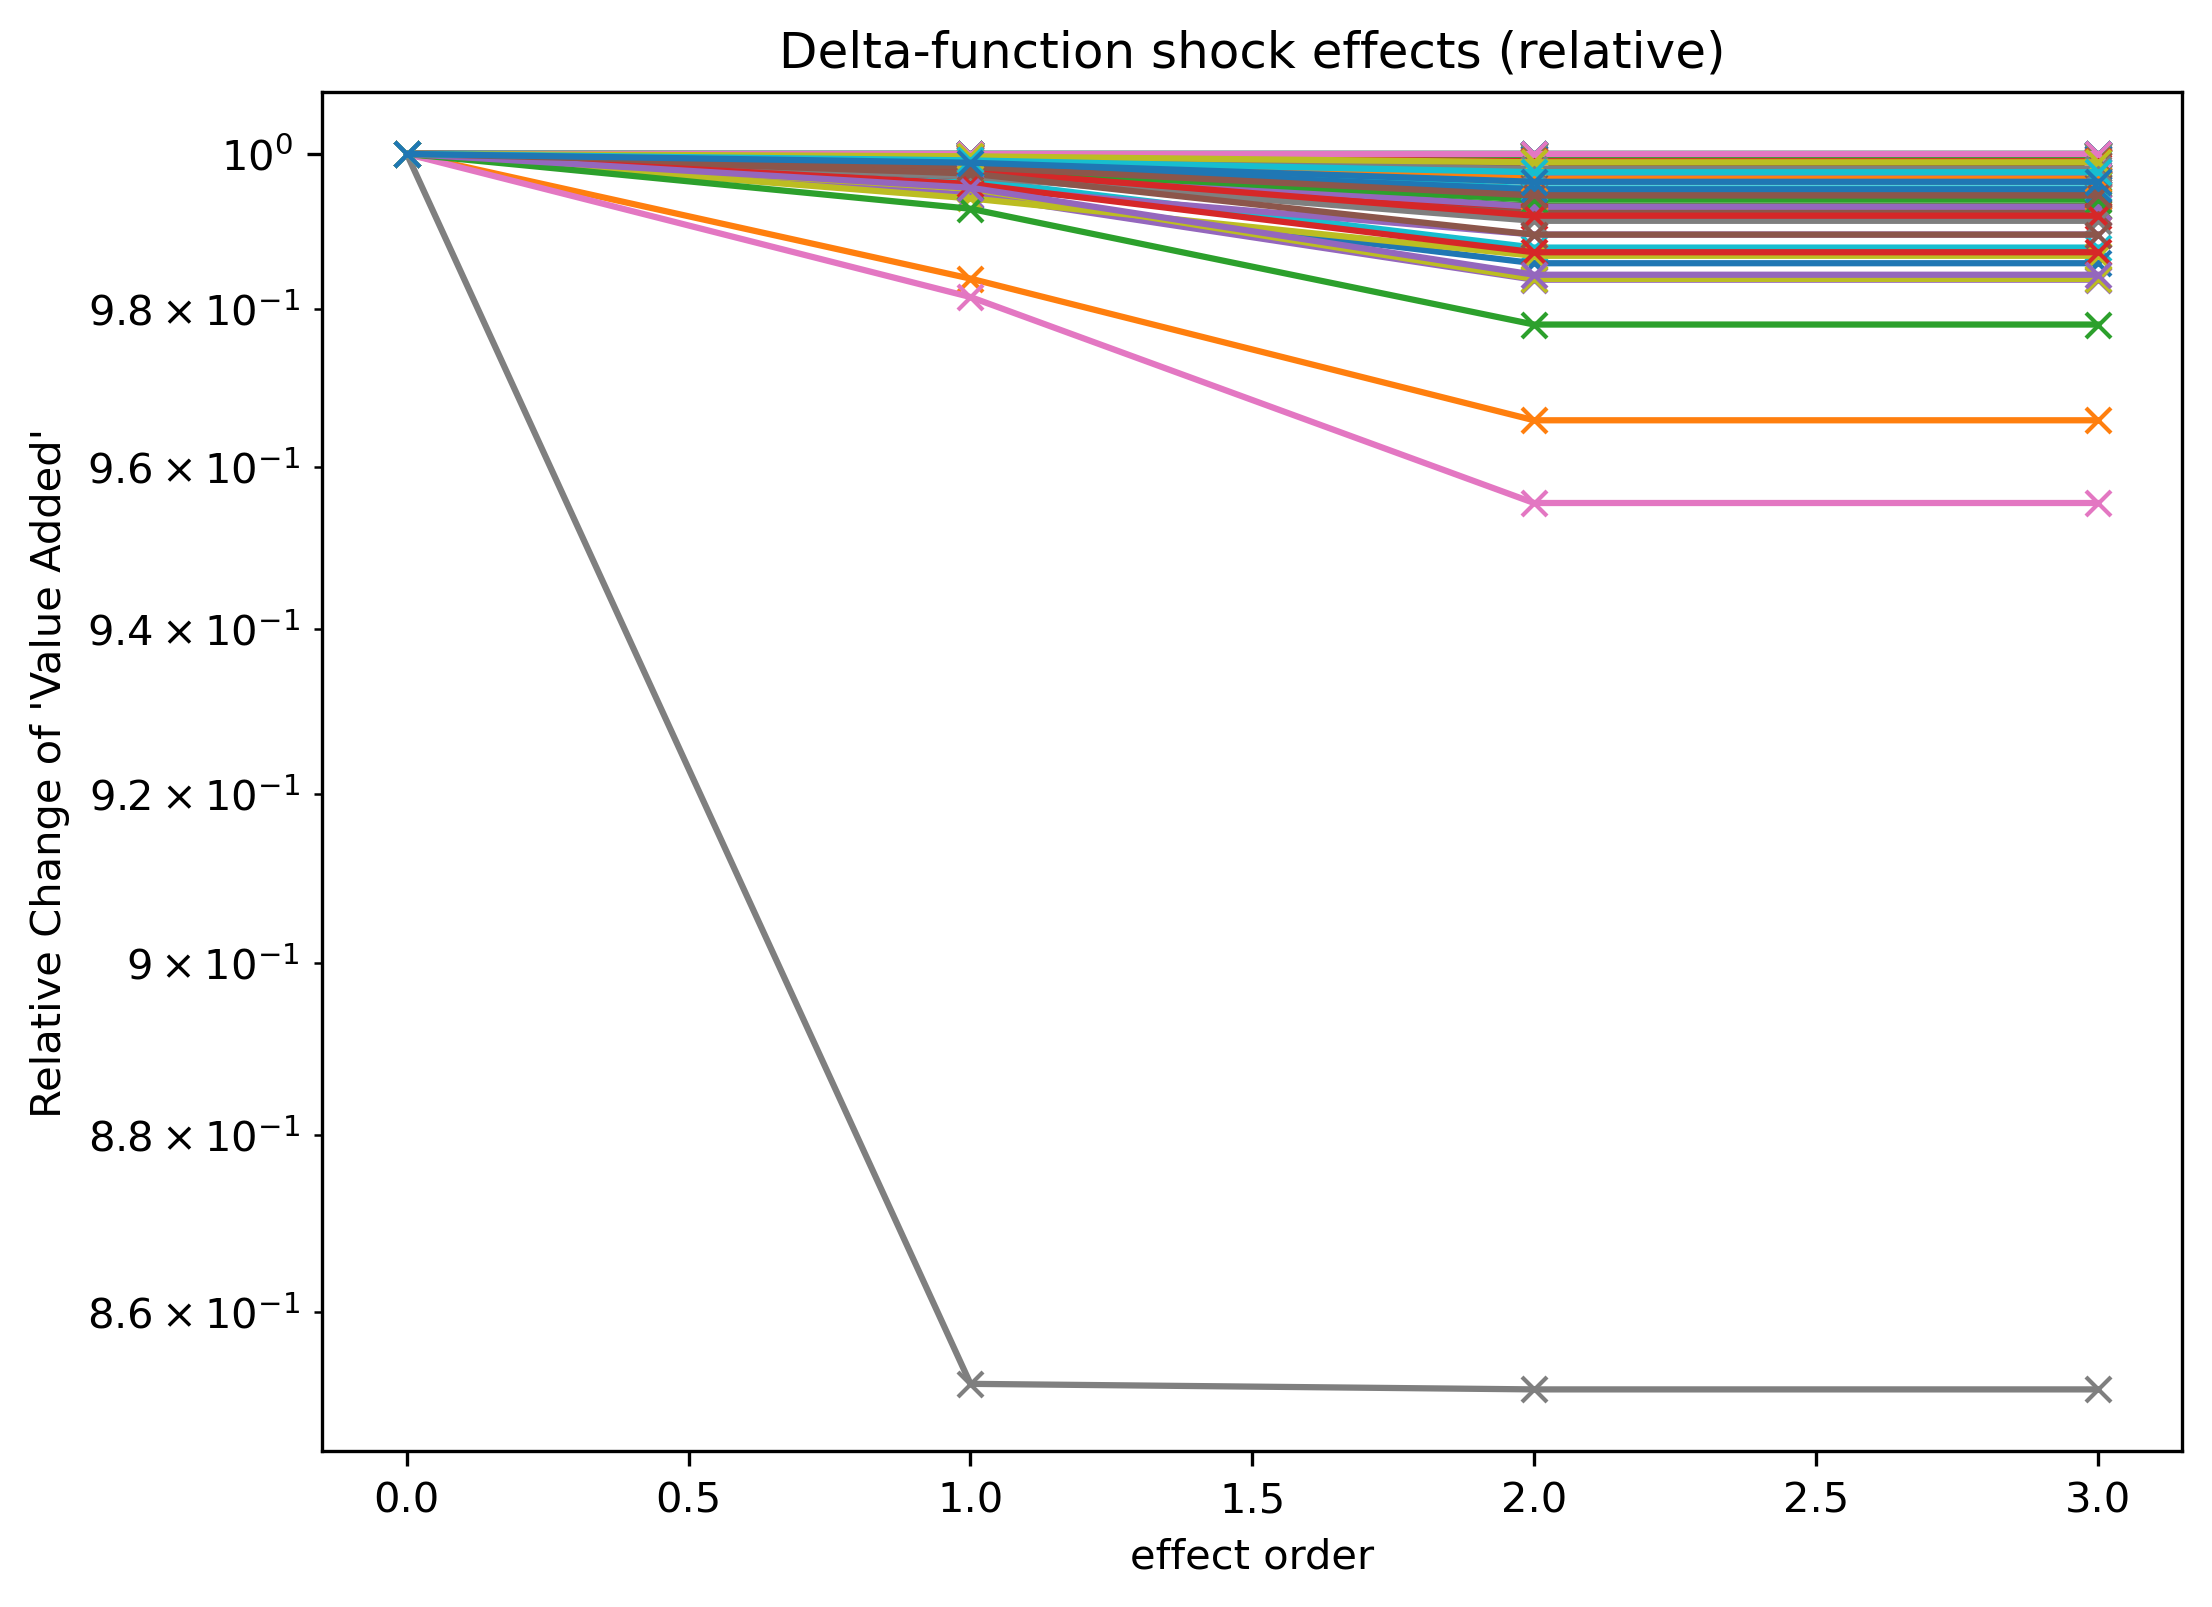

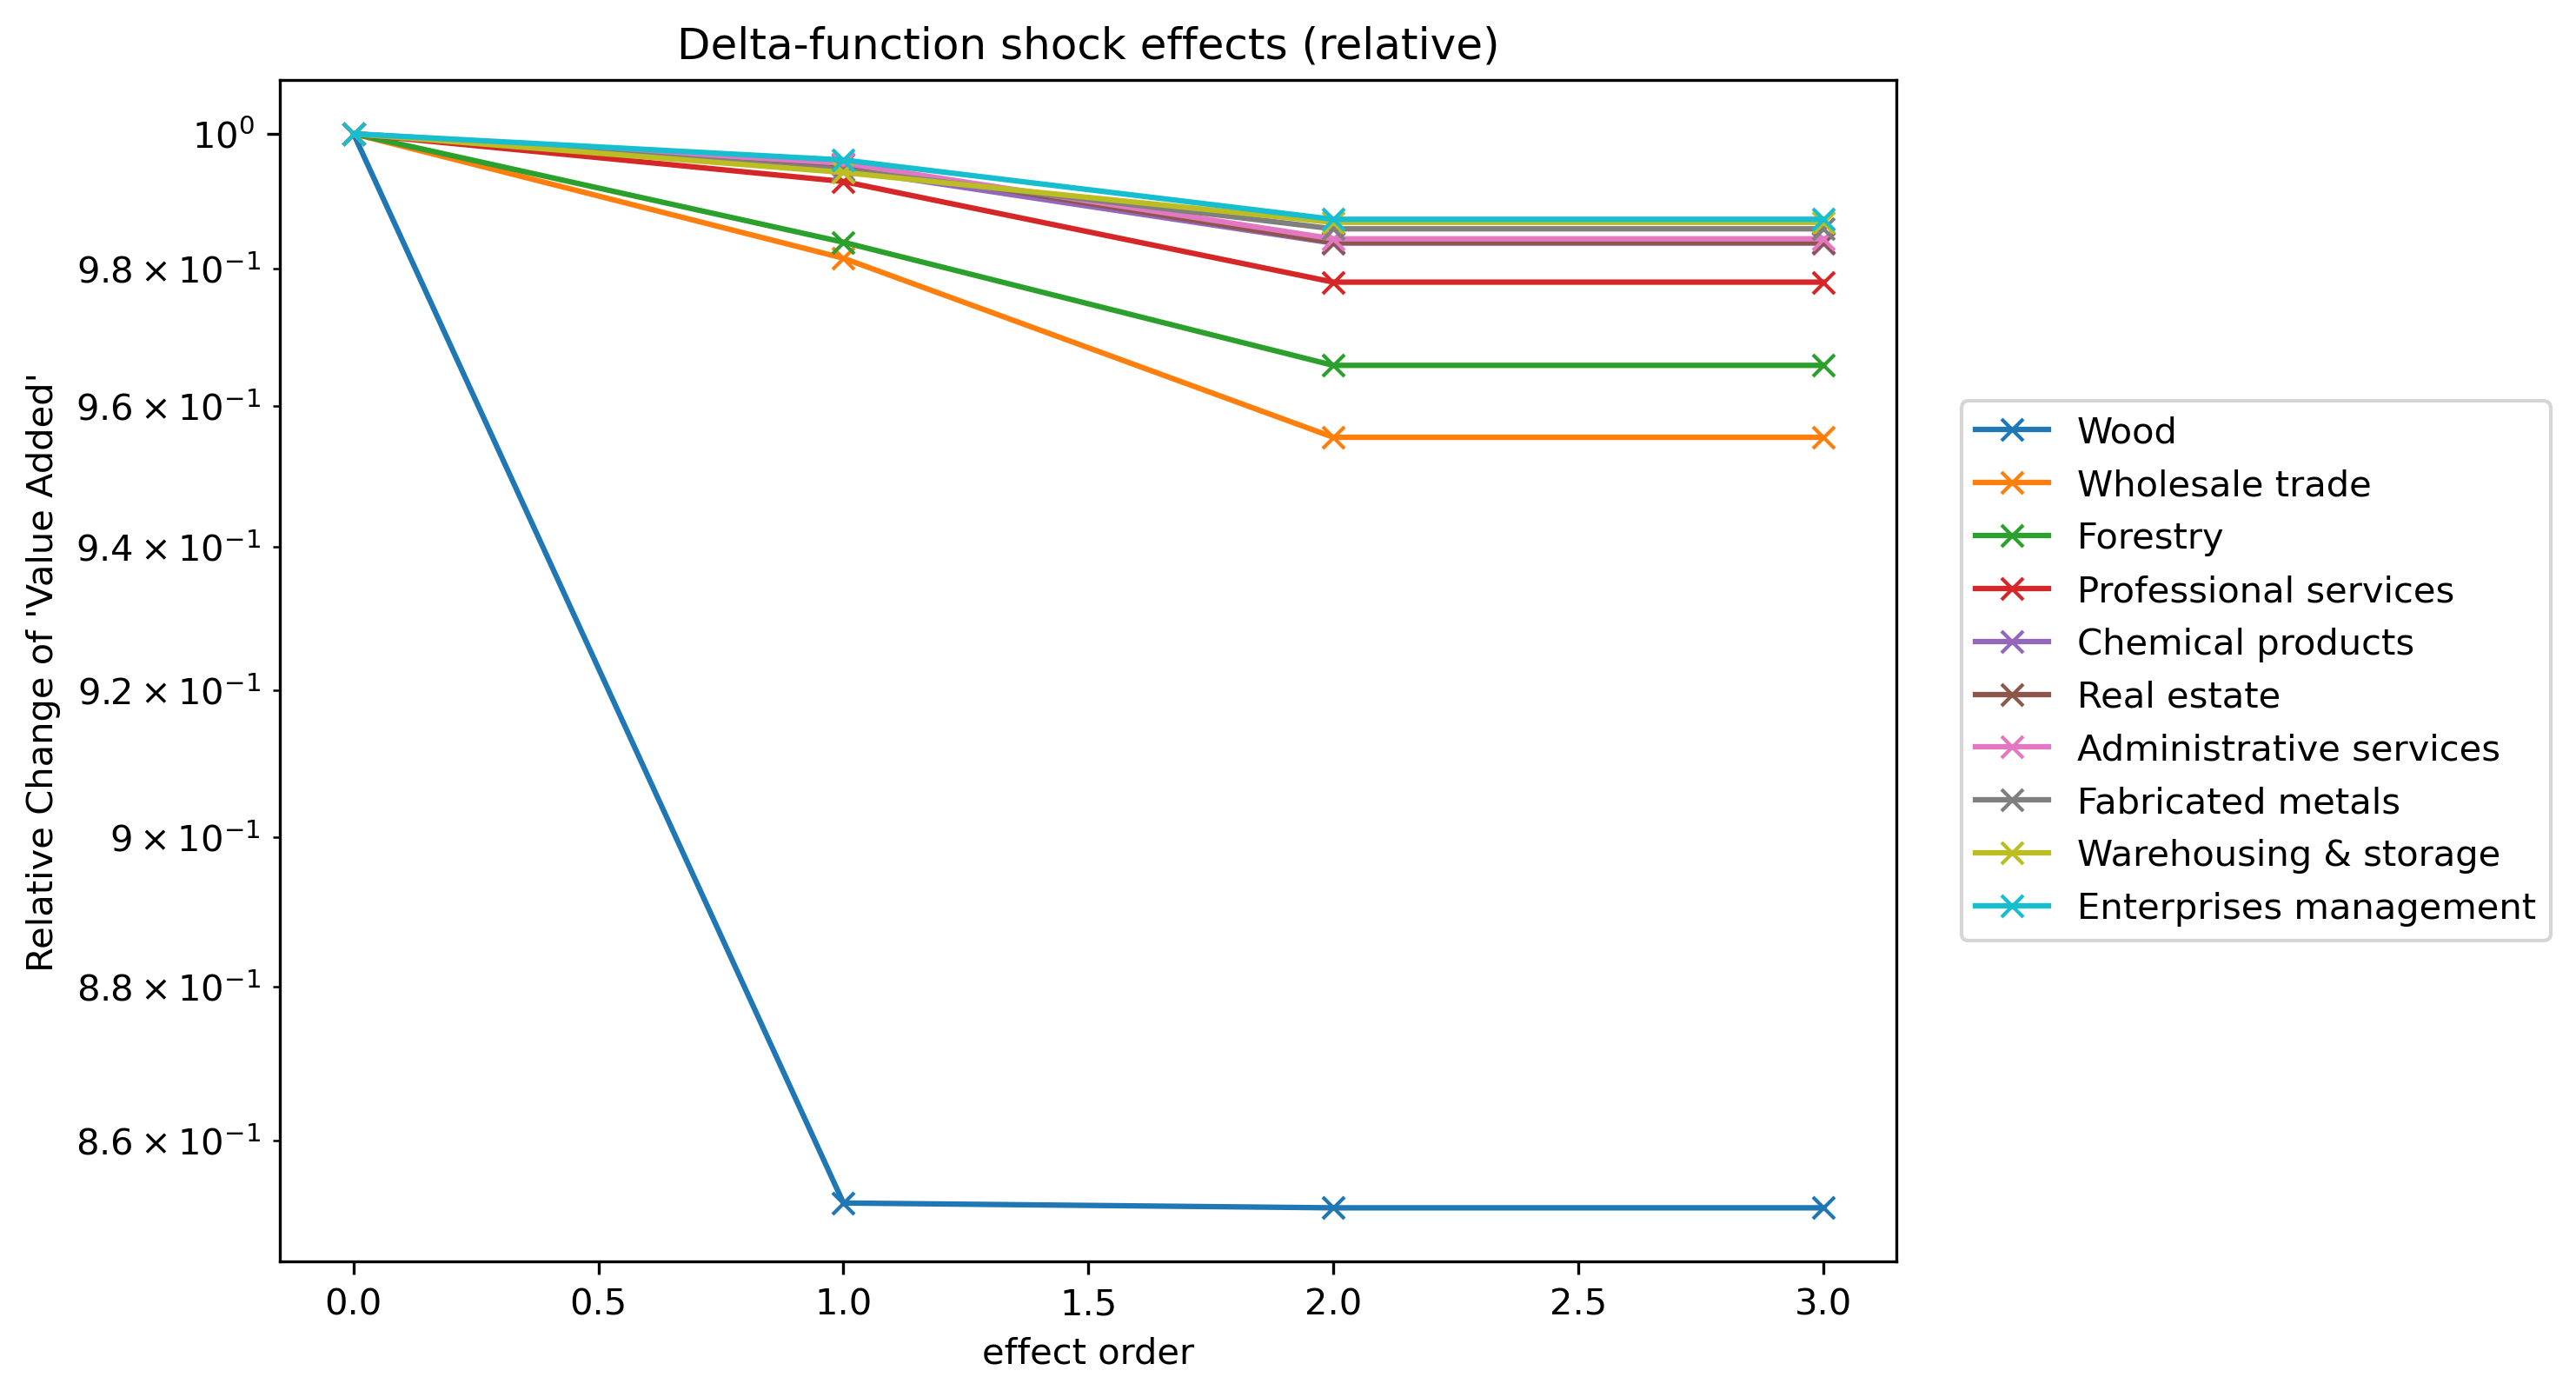

In [4]:
plot_experiment(name = "Wood", shock = -0.13, n = 10, year = 2020)

In [6]:
u = data.Use(2020)
s = data.Supply(2020)
c = data.C2CReqs(2020)
i = data.I2IReqs(2020)

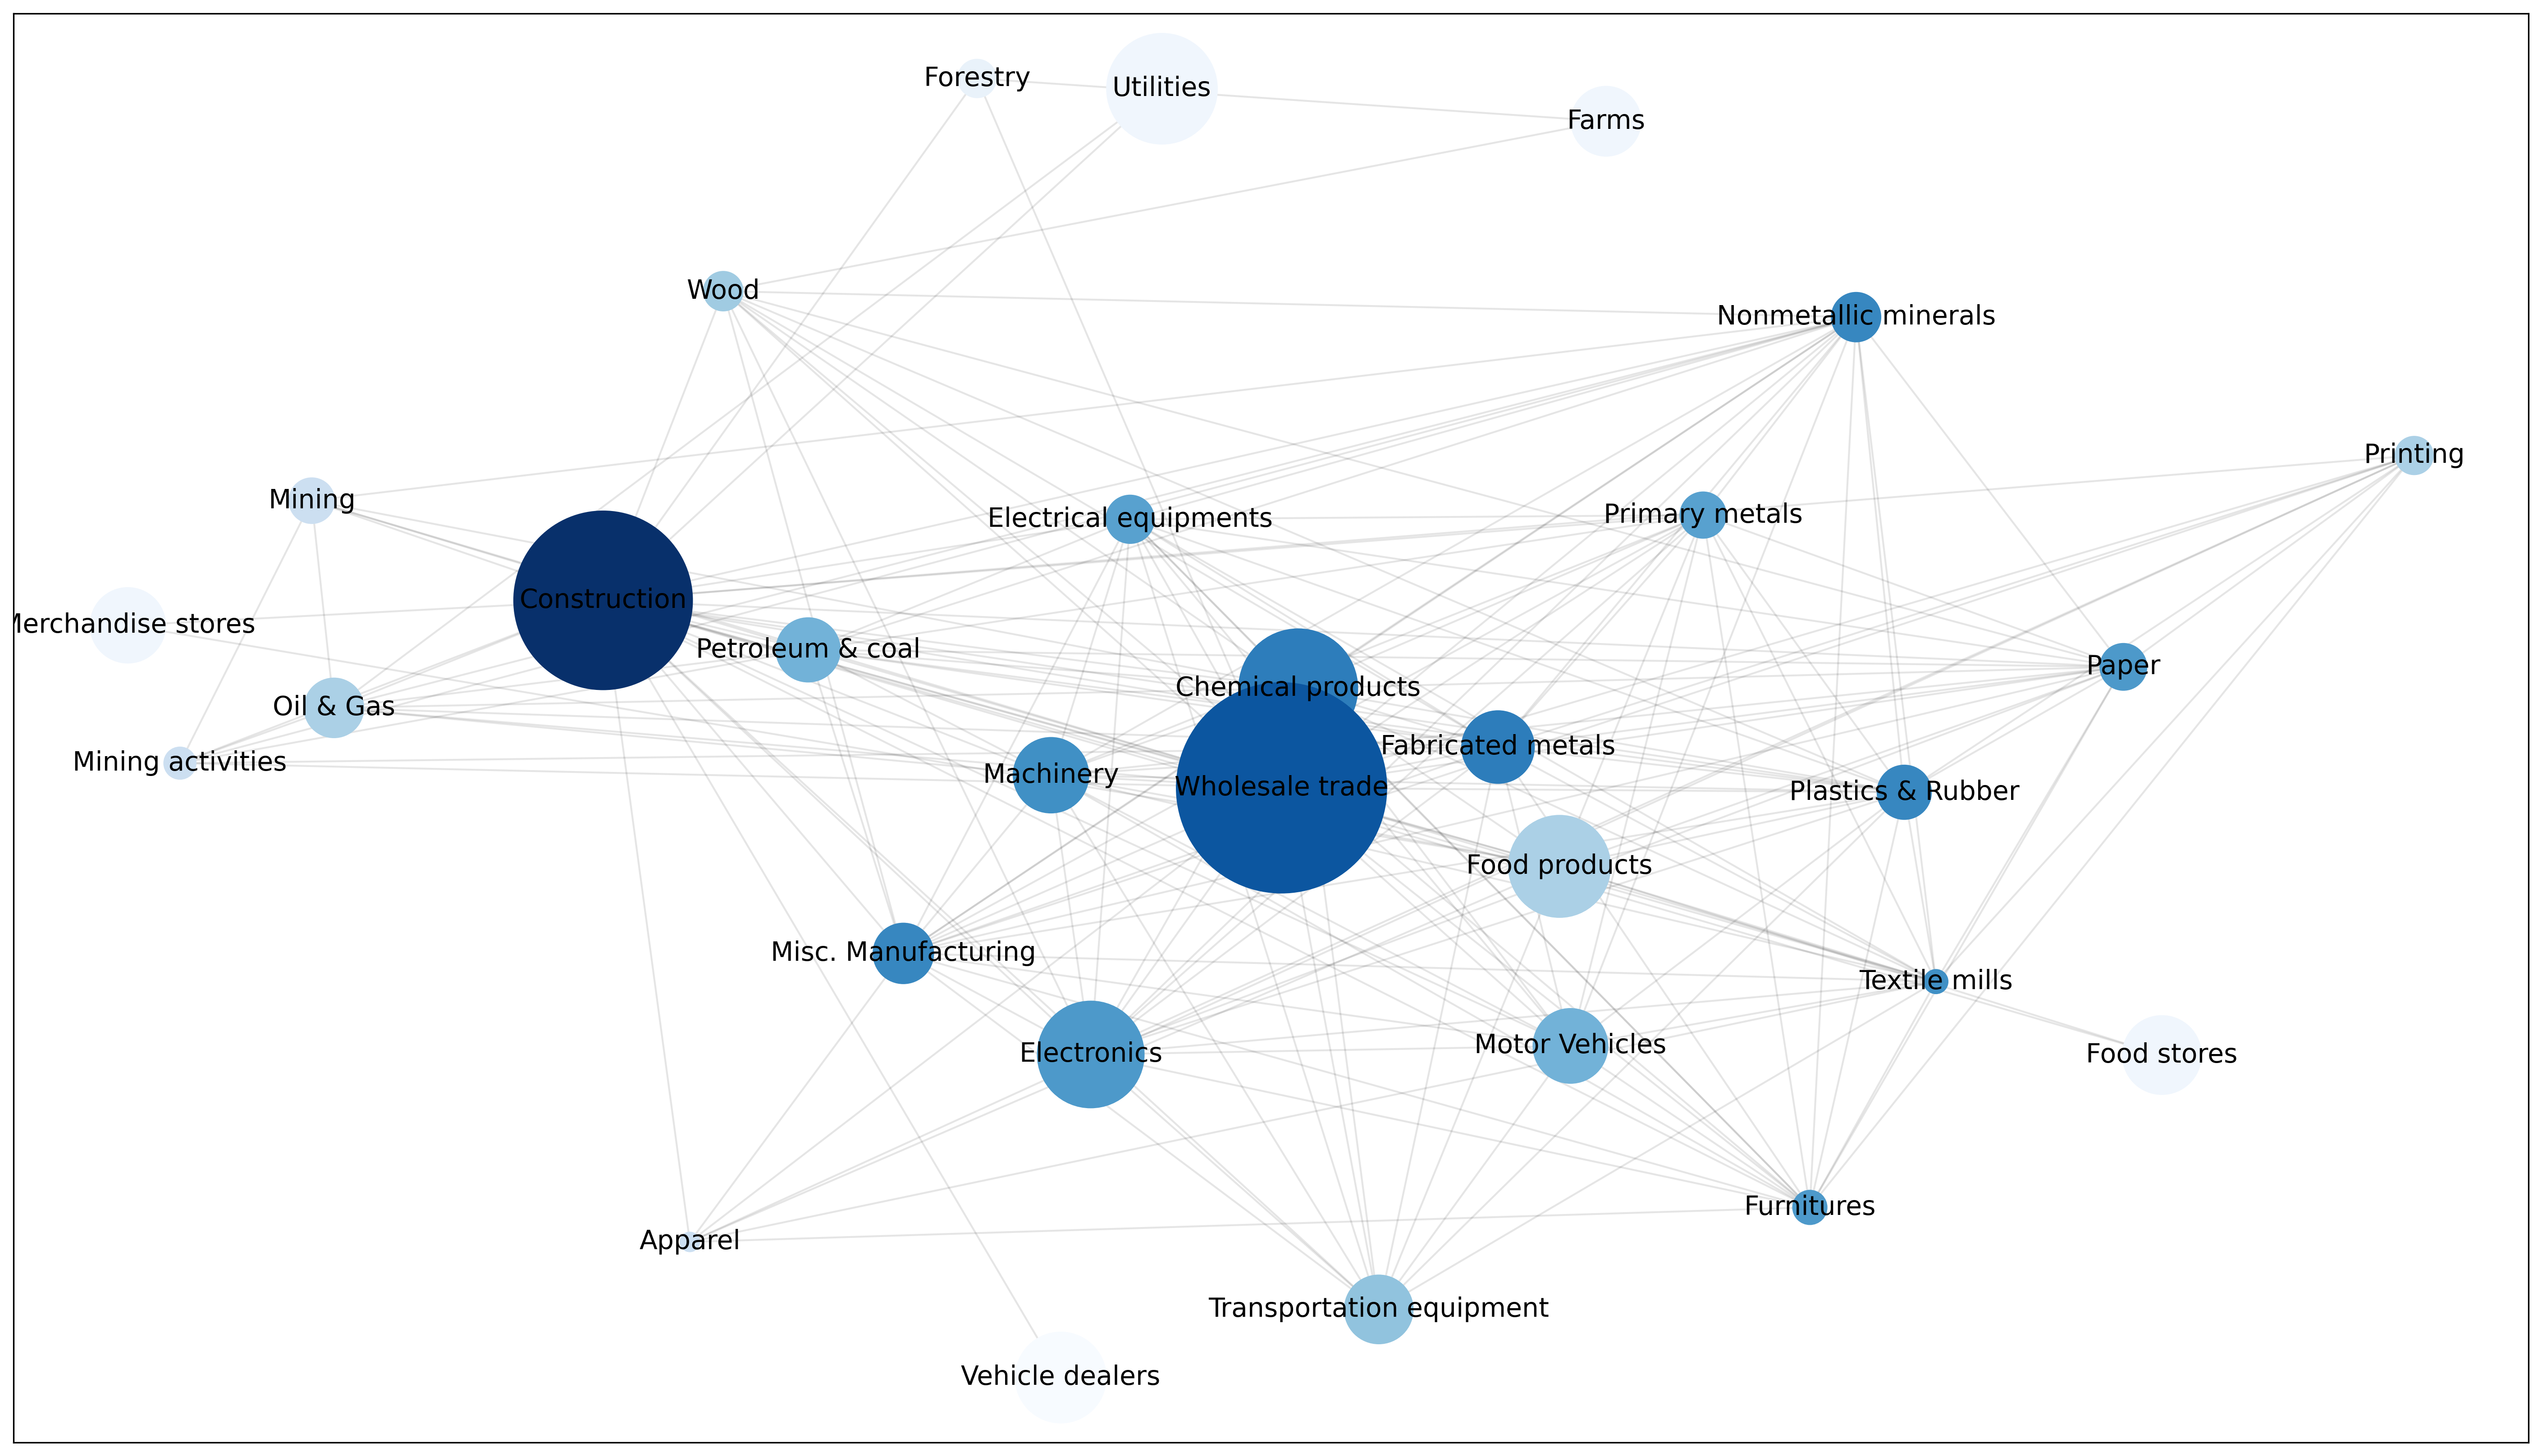

In [11]:
plt.figure(figsize=(24,14), dpi = 300)
s = data.Supply(2020)        
xxx = s.table.iloc[:30,:30]
G = nx.from_pandas_adjacency(xxx)
# Use spring_layout to handle positioning of graph
layout = nx.spring_layout(G, k = 15)
test = u.graph
value_added = u.table.iloc[-1].to_dict()
value_added
for i in list(G.nodes()):
            G.nodes[i]["value_added"] = value_added[i]
# Get weights of each edge and assign to labels
labels = [0.01 * nx.get_node_attributes(G, "value_added")[v] for v in G]
labels
node_color = [G.degree(v) for v in G]
#node_size = [0.005 * nx.get_edge_attributes(G, "weight")[v] for v in G]
nx.draw_networkx_nodes(G, pos = layout, node_size = labels, with_labels = True, node_color=node_color, cmap = plt.cm.Blues)
nx.draw_networkx_edges(G, pos = layout, alpha = 0.1)
nx.draw_networkx_labels(G, pos = layout, font_color = "black", font_size = 14, font_style = "bold")
#plt.axis('off')
plt.savefig('network.png', dpi=450)
plt.show()

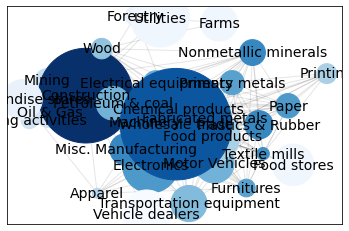

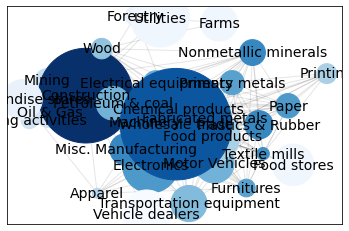

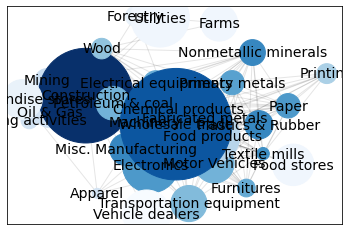

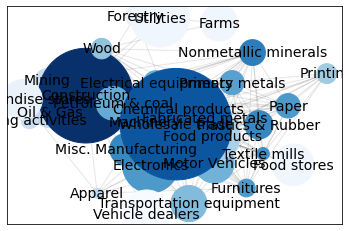

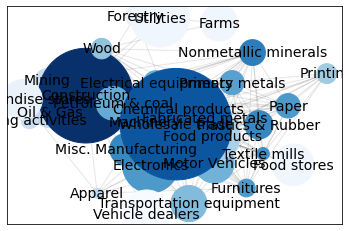

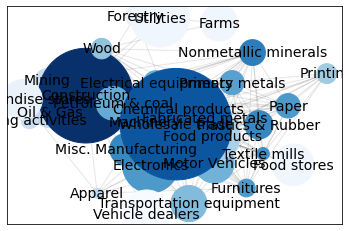

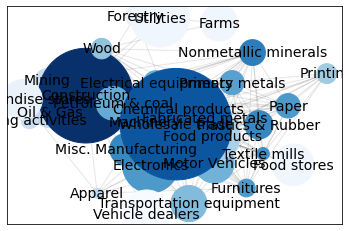

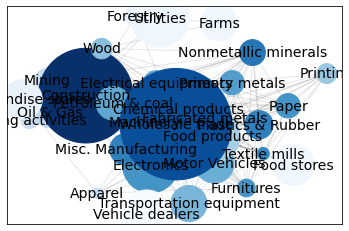

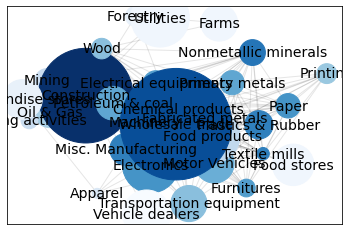

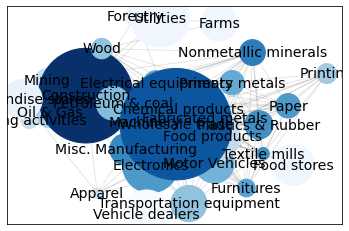

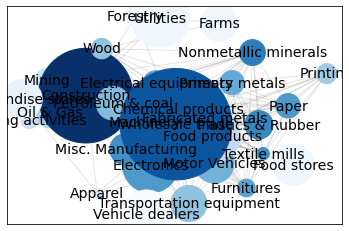

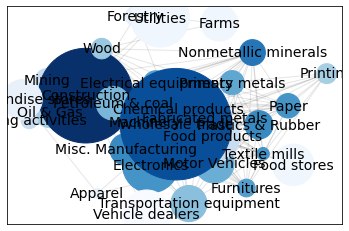

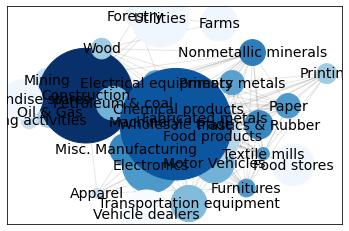

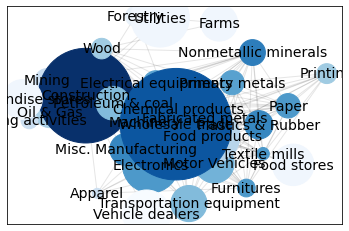

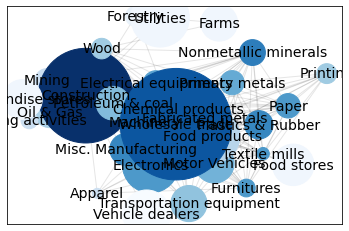

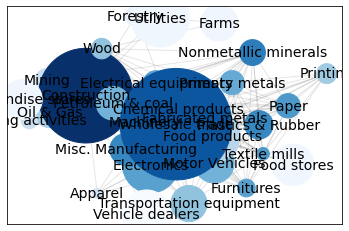

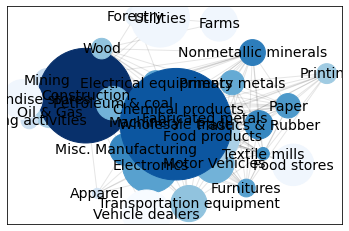

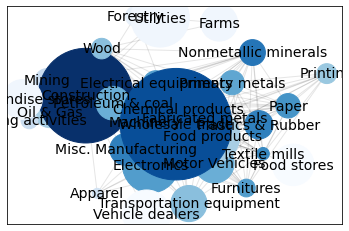

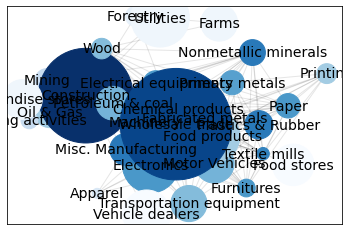

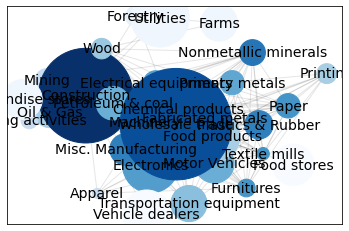

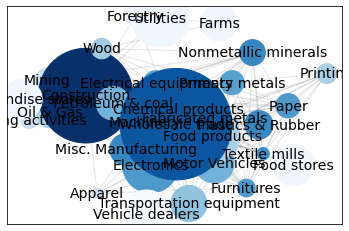

In [12]:
years = range(2000,2021)
for i in years:
    s = data.Supply(i)        
    xxx = s.table.iloc[:30,:30]
    G = nx.from_pandas_adjacency(xxx)
    # Use spring_layout to handle positioning of graph
    #layout = nx.spring_layout(G, k = 15)
    test = u.graph
    value_added = u.table.iloc[-1].to_dict()
    value_added
    for i in list(G.nodes()):
                G.nodes[i]["value_added"] = value_added[i]
    # Get weights of each edge and assign to labels
    labels = [0.01 * nx.get_node_attributes(G, "value_added")[v] for v in G]
    labels
    node_color = [G.degree(v) for v in G]
    #node_size = [0.005 * nx.get_edge_attributes(G, "weight")[v] for v in G]
    nx.draw_networkx_nodes(G, pos = layout, node_size = labels, with_labels = True, node_color=node_color,cmap = plt.cm.Blues)
    nx.draw_networkx_edges(G, pos = layout, alpha = 0.1)
    nx.draw_networkx_labels(G, pos = layout, font_color = "black", font_size = 14, font_style = "bold")
    #plt.axis('off')
    # plt.figure(figsize=(8,6), dpi = 300)
    plt.savefig('network.png', dpi=450)
    plt.show()

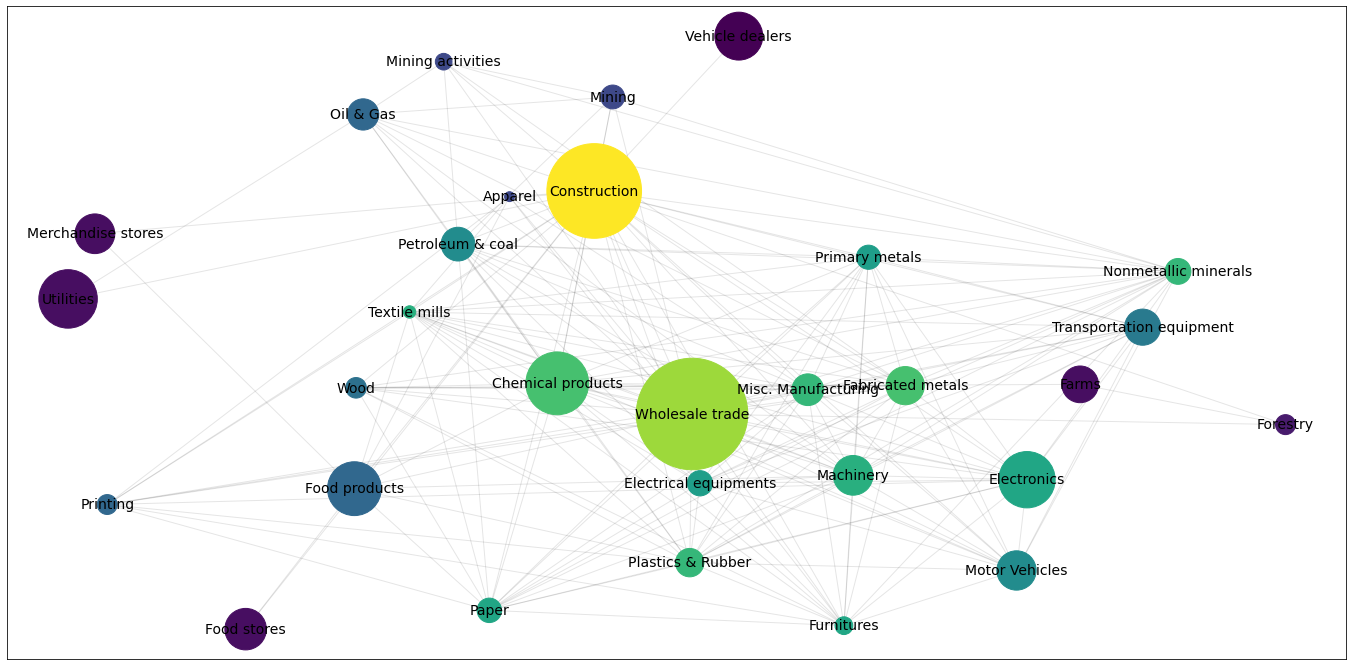

In [13]:
## DAG of above dataframe
plt.rcParams["figure.figsize"] = (24,12)
# Use spring_layout to handle positioning of graph
layout = nx.spring_layout(G, k = 15)
test = u.graph
value_added = u.table.iloc[-1].to_dict()
value_added
for i in list(G.nodes()):
            G.nodes[i]["value_added"] = value_added[i]
# Get weights of each edge and assign to labels
labels = [0.01 * nx.get_node_attributes(G, "value_added")[v] for v in G]
labels
node_color = [G.degree(v) for v in G]
#node_size = [0.005 * nx.get_edge_attributes(G, "weight")[v] for v in G]
nx.draw_networkx_nodes(G, pos = layout, node_size = labels, with_labels = True, node_color=node_color)
nx.draw_networkx_edges(G, pos = layout, alpha = 0.1)
nx.draw_networkx_labels(G, pos = layout, font_color = "black", font_size = 14, font_style = "bold")
#plt.axis('off')
plt.savefig('network.png', dpi=450)
plt.show()

# Objective

Explore the effects of supply-side shocks on the U.S. Economy through the lens of graph networks

# Defenitions

- **Supply tables:** The value of goods and services available in the U.S. economy, whether produced by domestic industries or imported. 
- **Use(IO) tables:** How the supply of goods and services is used. Includes purchases by U.S. industries, individuals, and government, and exports to foreign purchasers. This is the table we are actually interested in because $a_{ij}x_{j}$ is the total number of units (Millions of Dollars)

When it comes to the application of probabilsitc graph models to societal concerns, one need not look further than into public economic policy.

1. **Open Model:**
2. **Closed Model:**

In fact, these methods have proved particularly effective in the analysis of sudden and large changes, as in the case of military mobilization or other far-reaching tranformations of an economy. The method has also been applied in studies of how cost and price changes are transmitted through various sectors of an economy.

Among recent developments of the method may be mentioned its extension to include residuals of the production system – smoke, water pollution, scrap, etc., and the further processing of these. In this way the effects of the production on the environment can be studied.

# Setup

**Required:**
1. IO tables $\coloneqq$ Input-Output tables from 1997-2020 from BEA database
2. mapping.json $\coloneqq$ Dictionary containing shortened industry names
3. 'IO.py' $\coloneqq$ Python module containing IO class & functions for IO-dataframe -> networkX.G object

Please deploy the cells below and ensure that there are no errors; note that file paths may need to be changed to the directory where the data is stored on your local machine. More information on the data, mapping dictionary, and IO module may be found in `EDA-Andrew.ipynb`, where the function is built and we conduct a prelimiary EDA with visualzations.

# Model Implementation & Deployment

From a big picture perspective, we will be implementing a variety of proposed Economic Network models in published scientific journals. We will be starting with a relatively simple model porposed by .

From the algebra, one could easily mistake this for a trivial task; however, remember that our IO tables are of sizes. The following concerns must be investigated and adressed:

- How can we guarantee the nonsigularity of our input-output matrix A? 
- Should we utilize the psuedoinverse and how will taht affect the predictive power of our model? 
- How do we deal with the computational complaexity of possible inverting a ~100x100 matrix? 

For those of you interested, these articles may be found both linked in the model summaries below or at the end in the 'References' section. 

# Conclusion

# References

1. Jason Choi and Andrew Foerster, (2017), The Changing Input-Output Network Structure of the U.S. Economy, Economic Review, (Q II), 23-49
2. Sekhon, Rupinder, and Roberta Bloom. Applications – Leontief Models. De Anza College, 4 Sept. 2021, https://math.libretexts.org/@go/page/37851.